<a href="https://colab.research.google.com/github/B10956048/113_Finance/blob/main/1022_week7_%E5%A4%9A%E6%A8%A1%E6%85%8B_Multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

gdown可以下載存放在Google雲端的檔案，類似wget

gdown github: https://github.com/wkentaro/gdown

In [ ]:
# 使用gdown下載資料
!gdown 1bZREL8xxNX4Us5vYtgsg6TomMTdaUARC # Reddit新聞資料
!gdown 1PLO60_bOaIYKzyoGyZHqUMv7WckvJBEw # 道瓊股價資料

Downloading...
From: https://drive.google.com/uc?id=1bZREL8xxNX4Us5vYtgsg6TomMTdaUARC
To: /content/DJIA_table(train).csv
100% 150k/150k [00:00<00:00, 24.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PLO60_bOaIYKzyoGyZHqUMv7WckvJBEw
To: /content/RedditNews(train).csv
100% 9.10M/9.10M [00:00<00:00, 89.8MB/s]


# 資料集
* 文本資料：每日reddit新聞標題 - 代表市場情緒和輿論
* 股價資料：道瓊工業平均指數 - 代表市場實際表現

# 為什麼選擇這兩種資料？
1. 異質性：文本(非結構化) vs 數值(結構化) - 測試融合策略的效果
2. 時間序列性：都具有時間依賴性，適合LSTM處理
3. 相關性：新聞情緒理論上會影響股價，有內在關聯


資料集來源：https://www.kaggle.com/competitions/stock-market-prediction-and-sentimental-analysis/data

# 模型融合的各種型態
![多模態融合的各種形式](https://www.researchgate.net/publication/362028535/figure/fig2/AS:11431281126156761@1678559245845/llustration-of-early-fusion-late-fusion-and-middle-fusion-methods-used-by-multimodal.jpg)

本次作業主要實作的內容是(c)中期融合（Middle Fusion）

# 文本資料處理

## 目標：將新聞文本轉換為數值向量
新聞文本無法直接輸入機器學習模型，需要先轉換為數值表示


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

In [ ]:
import pandas as pd

# 讀取新聞資料
news_df = pd.read_csv('RedditNews(train).csv', encoding='utf-8')
# 資料清理：移除字串前後的 b'...' 標記
# 原因：原始資料中有些文本被存成 b'content' 格式，需要清理
# regex解釋：
#   ^b     - 匹配字串開頭的 'b'
#   ['\"]  - 匹配單引號或雙引號
#   |      - 或者
#   ['\"]$ - 匹配字串結尾的單引號或雙引號
news_df['News'] = news_df['News'].str.replace(r"^b['\"]|['\"]$", '', regex=True)
# 印出錢10筆資料
news_df.head(10)

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...
5,2016-07-01,Brazil: Huge spike in number of police killing...
6,2016-07-01,Austria's highest court annuls presidential el...
7,2016-07-01,"Facebook wins privacy case, can track any Belg..."
8,2016-07-01,Switzerland denies Muslim girls citizenship af...
9,2016-07-01,China kills millions of innocent meditators fo...


In [ ]:
# 查看每日新聞數量
date_counts = news_df['Date'].value_counts().reset_index()
# 根據日期排序
date_counts.sort_values(by='Date', ascending=True)

,Date,count
1214,2008-06-08,25
967,2008-06-09,25
966,2008-06-10,25
965,2008-06-11,25
964,2008-06-12,25
...,...,...
968,2016-06-27,25
1949,2016-06-28,25
1948,2016-06-29,25
1947,2016-06-30,25


In [ ]:
# 將每日新聞標題合併成一則新聞
# 目標：將同一天的多則新聞合併成單一文本
# 原因：模型需要每天一個輸入，而不是每天多個分散的新聞
news_dict = news_df.groupby('Date')['News'].apply(list).to_dict()
news_dict

In [ ]:
# 下載 Hugging Face Transformers
!pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
"""BERT文本編碼

為什麼使用BERT？
1. **語義理解**：BERT能理解詞語在上下文中的含義
2. **預訓練優勢**：已在大量文本上訓練，具備豐富語言知識
3. **向量化**：將文本轉換為768維的密集向量表示

技術細節
- 使用[CLS] token作為整體文本表示
- 每個新聞日期產生一個768維向量
- 這個向量包含了該日所有新聞的語義資訊
"""

# 初始化BERT模型和分詞器
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

# 設置為評估模式（關閉dropout等訓練相關功能）
# 原因：我們只用BERT做特徵提取，不進行訓練
bert_model.eval()
print('載入 BERT 成功')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

載入 BERT 成功


In [ ]:
# 設置設備（CPU/GPU/MPS）偵測使用什麼設備
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
# 將模型移動到訓練設備
bert_model.to(device)
print(f'模型目前使用{device}')

模型目前使用cuda


In [ ]:
"""#批次文本編碼處理

逐日處理新聞文本，將每天的所有新聞合併後輸入BERT
"""
date_embeddings = {} # 儲存每日的文本嵌入向量




# 逐日期處理
for date, news_list in news_dict.items():

    # 步驟1合併當天的所有新聞為一個文本（用空格分隔）
    # 原因：需要將一天內的多則新聞統合成單一語義表示
    combined_text = " ".join(news_list)
    # 步驟2：文本預處理和分詞
    # 將文本 Tokenize 並輸入到 BERT
    # max_length=512：BERT的最大輸入長度限制
    # truncation=True：如果超過長度就截斷
    inputs = tokenizer(combined_text, return_tensors="pt", truncation=True, max_length=512).to(device)
    outputs = bert_model(**inputs)
    print(f'{date} done.')

    # 提取[CLS] token的嵌入（位置0）作為整體文本表示
    # [CLS] token設計用來代表整個句子的語義
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0).detach().cpu().numpy()

    # 儲存該日期的語義向量
    date_embeddings[date] = cls_embedding

2008-06-08 done.
2008-06-09 done.
2008-06-10 done.
2008-06-11 done.
2008-06-12 done.
2008-06-13 done.
2008-06-14 done.
2008-06-15 done.
2008-06-16 done.
2008-06-17 done.
2008-06-18 done.
2008-06-19 done.
2008-06-20 done.
2008-06-21 done.
2008-06-22 done.
2008-06-23 done.
2008-06-24 done.
2008-06-25 done.
2008-06-26 done.
2008-06-27 done.
2008-06-28 done.
2008-06-29 done.
2008-06-30 done.
2008-07-01 done.
2008-07-02 done.
2008-07-03 done.
2008-07-04 done.
2008-07-05 done.
2008-07-06 done.
2008-07-07 done.
2008-07-08 done.
2008-07-09 done.
2008-07-10 done.
2008-07-11 done.
2008-07-12 done.
2008-07-13 done.
2008-07-14 done.
2008-07-15 done.
2008-07-16 done.
2008-07-17 done.
2008-07-18 done.
2008-07-19 done.
2008-07-20 done.
2008-07-21 done.
2008-07-22 done.
2008-07-23 done.
2008-07-24 done.
2008-07-25 done.
2008-07-26 done.
2008-07-27 done.
2008-07-28 done.
2008-07-29 done.
2008-07-30 done.
2008-07-31 done.
2008-08-01 done.
2008-08-02 done.
2008-08-03 done.
2008-08-04 done.
2008-08-05 don

In [ ]:
# 將嵌入字典轉換為DataFrame格式，方便後續處理
embedding_df = pd.DataFrame(date_embeddings).T  # 轉置：日期為行，特徵為列
embedding_df.columns = [f"Embedding_{i}" for i in range(embedding_df.shape[1])] # 重新命名列
embedding_df['Date'] = embedding_df.index
embedding_df['Date'] = pd.to_datetime(embedding_df['Date'], format='%Y-%m-%d') # 日期格式化
# 印出前10筆資料
embedding_df.head(10)

,Embedding_0,Embedding_1,Embedding_2,Embedding_3,Embedding_4,Embedding_5,Embedding_6,Embedding_7,Embedding_8,Embedding_9,...,Embedding_759,Embedding_760,Embedding_761,Embedding_762,Embedding_763,Embedding_764,Embedding_765,Embedding_766,Embedding_767,Date
2008-06-08,-0.198385,-0.144236,0.069488,-0.116309,-0.580700,-0.079995,0.494757,0.443124,-0.076045,0.114641,...,-0.348483,-0.013811,-0.261851,0.503283,0.217790,-0.336219,-0.541625,0.607868,0.182255,2008-06-08
2008-06-09,-0.373428,-0.108956,0.213794,0.027715,-0.406929,0.005849,0.508953,0.621934,-0.013783,0.037755,...,-0.312271,-0.028168,-0.026072,0.692208,0.319143,-0.068883,-0.479767,0.552667,0.220548,2008-06-09
2008-06-10,-0.298237,0.169268,-0.200818,0.205484,-0.390613,0.222000,0.576172,0.452965,-0.156957,-0.221062,...,-0.314229,-0.113797,-0.081354,0.679748,-0.101922,-0.180870,-0.502713,0.635183,0.308270,2008-06-10
2008-06-11,-0.308372,0.152368,-0.019860,0.143967,-0.314442,-0.107859,0.753128,0.459349,-0.124832,-0.110088,...,-0.180412,0.017787,-0.260838,0.623176,0.150097,-0.012497,-0.511633,0.652203,0.114420,2008-06-11
2008-06-12,-0.311589,-0.231446,0.053513,0.086309,-0.580402,0.112451,0.652200,0.742272,-0.447851,0.139580,...,-0.069649,-0.029915,-0.243500,0.761308,0.002478,0.044297,-0.452780,0.748016,0.203376,2008-06-12
2008-06-13,-0.426811,-0.278478,-0.026197,-0.048785,-0.603455,0.103328,0.442665,0.388249,-0.075060,-0.160268,...,-0.133991,0.147489,-0.398242,0.490477,-0.007113,-0.459362,-0.339614,0.967528,0.153802,2008-06-13
2008-06-14,-0.423142,-0.201393,-0.059159,0.069293,-0.537429,0.277443,0.810042,0.605696,-0.436974,0.041915,...,-0.229241,-0.013497,-0.193860,0.850519,-0.363265,-0.153338,-0.536058,0.615055,-0.023131,2008-06-14
2008-06-15,-0.418540,0.027653,-0.032037,0.210869,-0.439750,-0.228440,0.657617,0.517551,0.045715,0.031138,...,-0.230459,-0.112386,-0.088031,0.676507,0.278952,-0.042537,-0.547856,0.899336,0.310912,2008-06-15
2008-06-16,-0.336062,-0.160597,0.190049,-0.250919,-0.780718,-0.116191,0.706152,0.412468,0.343830,-0.635814,...,-0.242541,-0.119734,-0.315148,0.409416,0.540449,-0.326974,-0.631223,0.750271,0.449715,2008-06-16
2008-06-17,-0.534123,-0.073870,0.082975,0.052447,-0.826066,-0.137178,0.872317,0.619862,-0.152562,0.004205,...,-0.573096,-0.038707,-0.055669,0.818371,-0.152756,-0.220881,-0.610287,0.584515,0.054854,2008-06-17


# 股價資料處理

# 目標：準備時間序列數值特徵
股價資料包含開盤價、收盤價、最高價、最低價、成交量等
我們主要使用收盤價作為預測目標的基準


In [ ]:
# 讀取股價資料
stock_data = pd.read_csv('DJIA_table(train).csv', encoding='utf-8')
# 日期欄位轉換成 datetime 格式
stock_data['Date'] = pd.to_datetime(stock_data['Date'], dayfirst=True)
# 設定日期為索引
stock_data.set_index('Date', inplace=True)
# 根據日期排序
stock_data = stock_data.sort_index()
# 印出前10筆
stock_data.head(10)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2008-08-08,11432.08984,11759.95996,11388.04004,11734.32031,212830000,11734.32031
2008-08-11,11729.66992,11867.11035,11675.53027,11782.34961,183190000,11782.34961
2008-08-12,11781.70020,11782.34961,11601.51953,11642.46973,173590000,11642.46973
2008-08-13,11632.80957,11633.78027,11453.33984,11532.95996,182550000,11532.95996
2008-08-14,11532.07031,11718.28027,11450.88965,11615.92969,159790000,11615.92969
2008-08-15,11611.20996,11709.88965,11599.73047,11659.90039,215040000,11659.90039
2008-08-18,11659.65039,11690.42969,11434.12012,11479.38965,156290000,11479.38965
2008-08-19,11478.08984,11478.16992,11318.50000,11348.54981,171580000,11348.54981
2008-08-20,11345.94043,11454.15039,11290.58008,11417.42969,144880000,11417.42969


In [ ]:
"""
多模態資料合併
目標：將文本特徵和數值特徵按日期對齊
這是多模態學習的關鍵步驟：確保不同模態的資料在時間維度上對應
"""

# 只保留收盤價
price_df = stock_data[['Close']]
# 根據日期合併收盤價和嵌入
combined_df = pd.merge(price_df, embedding_df, on='Date')
# 設定日期為索引
combined_df.set_index('Date', inplace=True)
# 根據日期排序
combined_df = combined_df.sort_index()
# 印出前10筆
combined_df.head(10)

,Close,Embedding_0,Embedding_1,Embedding_2,Embedding_3,Embedding_4,Embedding_5,Embedding_6,Embedding_7,Embedding_8,...,Embedding_758,Embedding_759,Embedding_760,Embedding_761,Embedding_762,Embedding_763,Embedding_764,Embedding_765,Embedding_766,Embedding_767
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,11734.32031,-0.587835,-0.366375,-0.047286,0.251385,-0.288917,-0.134200,0.502416,0.647066,-0.215660,...,0.163377,-0.142308,-0.011646,-0.165887,0.523895,0.376322,-0.029254,-0.631961,0.825019,0.024389
2008-08-11,11782.34961,-0.372291,-0.073399,-0.045990,-0.246410,-1.007252,-0.439152,0.693775,0.455300,0.493247,...,-0.093508,-0.134052,0.072778,-0.283020,0.313297,0.469278,-0.104069,-0.700979,0.682417,0.643971
2008-08-12,11642.46973,-0.309147,-0.247977,0.048171,0.306066,-0.711929,-0.425101,0.486479,0.383024,-0.224489,...,-0.025536,-0.082164,-0.057128,-0.488836,0.577513,0.601292,-0.270337,-0.483384,0.974845,0.388392
2008-08-13,11532.95996,-0.687628,-0.019728,0.055199,0.091955,-0.584213,-0.226257,0.584099,0.462233,-0.168849,...,-0.081513,-0.413259,0.076321,-0.051562,0.768652,0.410531,-0.003034,-0.753175,0.771645,0.230110
2008-08-14,11615.92969,-0.777364,-0.162012,0.046284,0.115582,-0.646037,-0.119226,0.681137,0.683649,-0.064202,...,0.206974,-0.051016,0.128415,-0.322207,0.751825,-0.066170,-0.232907,-0.651432,0.751075,-0.171825
2008-08-15,11659.90039,-0.738209,-0.010975,0.029411,0.159827,-0.654928,-0.005206,0.793559,0.419815,-0.157837,...,0.039288,-0.265279,-0.167255,-0.094613,0.875694,0.061983,-0.082314,-0.544599,0.632400,0.238414
2008-08-18,11479.38965,-0.302304,-0.176837,0.074325,-0.030866,-0.307285,-0.244708,0.716299,0.628725,-0.589513,...,-0.435481,-0.203127,-0.052375,-0.300021,0.762072,-0.039617,0.077357,-0.752745,0.496075,0.347063
2008-08-19,11348.54981,-0.746435,-0.145463,-0.027559,-0.026808,-0.897140,0.298353,1.170426,0.886130,-0.428304,...,-0.223896,-0.295141,0.058166,-0.415449,0.677329,0.046283,-0.119660,-0.844477,0.733347,-0.089476
2008-08-20,11417.42969,-0.338771,-0.102513,0.150072,0.100435,-0.526808,0.008705,0.769964,0.998814,-0.168159,...,0.063494,-0.284538,-0.098314,-0.235396,0.787472,0.038077,-0.115460,-0.617311,0.838304,0.051625


# 資料標記、滑動窗口

# 目標：創建預測標籤和時間序列窗口
1. **技術指標**：使用移動平均線判斷趨勢
2. **標籤策略**：短期均線>長期均線 = 多頭(1)，否則為空頭(0)
3. **滑動窗口**：將連續N天的資料作為一個訓練樣本

# 為什麼用移動平均交叉？
- **降噪**：平滑價格波動，減少雜訊
- **趨勢識別**：短長期均線交叉是經典的技術分析信號
- **實用性**：在實際交易中廣泛使用的策略



In [ ]:
import numpy as np

# 加入均線（後續標記漲跌用）
def add_MA(df, short_window=5, long_window=20):
    """
    添加移動平均線技術指標

    參數:
        df: 包含價格資料的DataFrame
        short_window: 短期移動平均窗口（預設5天）
        long_window: 長期移動平均窗口（預設20天）

    原理:
        - 短期均線反應近期價格變化
        - 長期均線反映整體趨勢
        - 兩者交叉點常被視為趨勢轉換信號
    """
    df['MA_short'] = df['Close'].rolling(window=short_window).mean()
    df['MA_long'] = df['Close'].rolling(window=long_window).mean()
    return df

# 標記漲跌
def create_labels(df):
    """
    根據移動平均線交叉創建分類標籤

    標籤邏輯:
        1 (多頭): 短期均線 > 長期均線，預期上漲
        0 (空頭): 短期均線 ≤ 長期均線，預期下跌

    這種標籤策略的優點:
        - 基於技術分析理論
        - 自動識別趨勢方向
        - 適合機器學習的二分類任務
    """
    # 計算移動平均線
    df = add_MA(df.copy())

    # 標記漲跌：短期均線在長期均線上方為1（多頭），下方為0（空頭）
    df['Target'] = (df['MA_short'] > df['MA_long']).astype(int)

    # 移除包含 NaN 的行（因為計算均線導致的）
    df = df.dropna()

    print("多頭信號（1）數量:", sum(df['Target'] == 1))
    print("空頭信號（0）數量:", sum(df['Target'] == 0))

    return df

# 準備序列資料
def prepare_sequence_data(df, sequence_length=5):
    """
    準備時間序列滑動窗口資料

    參數:
        df: 包含特徵和標籤的DataFrame
        sequence_length: 滑動窗口長度（預設5天）

    滑動窗口原理:
        - 使用過去N天的資料預測第N+1天
        - 例如：用第1-5天的資料預測第6天
        - 這樣可以讓模型學習時間序列的模式

    輸出:
        X_price: 價格時間序列 [樣本數, 時間步, 價格特徵數]
        X_news: 新聞時間序列 [樣本數, 時間步, 新聞特徵數]
        y: 對應的標籤 [樣本數]
    """
    # 分離特徵
    price_cols = ['Close', 'MA_short', 'MA_long']  # 價格相關特徵，現在包含均線
    news_cols = [col for col in df.columns if col.startswith('Embedding_')] # 新聞嵌入特徵

    X_price, X_news, y = [], [], []

    for i in range(len(df) - sequence_length):
        # 提取時間窗口內的價格序列
        # 價格序列（包含均線）
        price_seq = df[price_cols].iloc[i:i+sequence_length].values
        X_price.append(price_seq) # 添加至清單中
        # 提取時間窗口內的新聞序列
        # 新聞序列
        news_seq = df[news_cols].iloc[i:i+sequence_length].values
        X_news.append(news_seq) # 添加至清單中
        # 提取預測目標（窗口後一天的標籤）
        # 目標值
        y.append(df['Target'].iloc[i+sequence_length]) # 添加至清單中

    return np.array(X_price), np.array(X_news), np.array(y)

'''函數呼叫'''
# 加入均線
combined_df = add_MA(combined_df)

# 使用均線標記漲跌
combined_df = create_labels(combined_df)

# 創建序列資料
X_price, X_news, y = prepare_sequence_data(combined_df, sequence_length=5)

多頭信號（1）數量: 1132
空頭信號（0）數量: 712


In [ ]:
"""
資料分割與標準化

目標：準備訓練和測試集
  1. 時間分割：按時間順序分割，避免未來資訊洩漏
  2. 標準化：統一特徵尺度，提升模型訓練效果
"""
# 切分訓練集和測試集(80%訓練，20%測試)
# 重要：按時間順序分割，不隨機打亂（避免時間洩漏）
split_index = int(len(X_price) * 0.8)

# 股價序列
X_price_train = X_price[:split_index]
X_price_test = X_price[split_index:]

# 新聞序列
X_news_train = X_news[:split_index]
X_news_test = X_news[split_index:]

# 目標值（0:跌, 1:漲）
y_train = y[:split_index]
y_test = y[split_index:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 標準化收盤價
price_scaler = MinMaxScaler()
X_price_train_scaled = price_scaler.fit_transform(X_price_train.reshape(-1, 1)).reshape(X_price_train.shape)
X_price_test_scaled = price_scaler.transform(X_price_test.reshape(-1, 1)).reshape(X_price_test.shape)

In [ ]:
# 顯示訓練資料集和測試資料集的大小 (資料筆數, 特徵數)
print('訓練集形狀：', X_price_train_scaled.shape, X_news_train.shape, y_train.shape)
print('測試集形狀：', X_price_test_scaled.shape, X_news_test.shape, y_test.shape)

訓練集形狀： (1471, 5, 3) (1471, 5, 768) (1471,)
測試集形狀： (368, 5, 3) (368, 5, 768) (368,)


# 建立模型-多模態融合模型建構

## 核心概念：不同的融合時機

### 1. **Early Fusion (早期融合)**
- **融合點**：輸入層
- **特點**：直接串接原始特徵
- **優勢**：結構簡單，計算效率高
- **劣勢**：可能造成特徵混雜，難以發揮各模態優勢

### 2. **Middle Fusion (中期融合)**
- **融合點**：特徵層
- **特點**：各模態先獨立處理，再融合特徵
- **優勢**：平衡獨立性與交互性
- **劣勢**：需要設計融合點

### 3. **Late Fusion (晚期融合)**
- **融合點**：決策層
- **特點**：各模態完全獨立預測，最後合併決策
- **優勢**：保持模態獨立性，可解釋性強
- **劣勢**：可能錯失深層交互機會

In [ ]:
""" 建立模型

## 作業重點：
**只需要修改下面的 fusion_type 參數，嘗試不同的融合方式！**

### 選擇融合方式：
- `fusion_type = "early"`   # 早期融合
- `fusion_type = "middle"`  # 中期融合 (base)
- `fusion_type = "late"`    # 晚期融合
"""

import tensorflow as tf # 引入tensorflow框架
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import (
    Input,  # 輸入層
    LSTM, # 長短期記憶
    Dense, # 全鏈接層
    Concatenate, # 合併層，這邊用來合併文本與數值特徵
    TimeDistributed, # 為了讓降維時不影響時間維度（窗口）
    Flatten, # 展平層
    Average, # 平均層
    Dropout # 隨機失活 - 防止過擬合
)

def build_multimodal_model(sequence_length, fusion_type="middle"):
    """
    建立多模態融合模型

    參數:
        sequence_length: 時間序列長度（預設5天）
        fusion_type: 融合策略 ("early", "middle", "late")

    只需要修改fusion_type參數，就能體驗不同融合方式的效果
    """

    print(f"建立 {fusion_type.upper()} 融合模型...")

    # 輸入層定義（三種方式都相同）
    # price_input: [batch_size, sequence_length, 3] - 3個價格特徵
    price_input = Input(shape=(sequence_length, 3), name='price_input')
    # news_input: [batch_size, sequence_length, 768]
    news_input = Input(shape=(sequence_length, 768), name='news_input')

    if fusion_type == "early":
        # ========== 早期融合：輸入層直接合併 ==========
        print("早期融合：在輸入層直接串接特徵")

        # 步驟1：新聞特徵降維（避免維度不平衡）
        # 原因：新聞768維 vs 價格3維，維度差異太大，需要平衡
        # TimeDistributed：確保降維操作在每個時間步都執行
        news_reduced = TimeDistributed(Dense(32, activation='relu'),
                                     name='news_dim_reduction')(news_input)

        # 步驟2：特徵直接串接
        # 將價格[batch, 5, 3]和降維新聞[batch, 5, 32]串接成[batch, 5, 35]
        fused_features = Concatenate(axis=-1, name='early_fusion')([price_input, news_reduced])

        # 步驟3：統一LSTM處理混合特徵
        # 使用較大的LSTM(64)來處理複雜的混合特徵
        lstm_out = LSTM(64, name='unified_lstm')(fused_features)
        lstm_out = Dropout(0.2)(lstm_out)
        dense = Dense(32, activation='relu', name='dense_layer')(lstm_out)
        output = Dense(1, activation='sigmoid', name='output_layer')(dense)

    elif fusion_type == "middle":
        # ========== 中期融合：特徵層合併 ==========
        print("中期融合：分別處理後在特徵層合併")

        # 價格處理分支
        # 直接用LSTM處理價格時間序列，學習價格模式
        price_lstm = LSTM(32, name='price_lstm')(price_input)

        # 新聞處理分支
        # 先降維再用LSTM，學習新聞語義的時間演化
        news_dense = TimeDistributed(Dense(32), name='news_dense')(news_input)
        news_lstm = LSTM(16, name='news_lstm')(news_dense)

        # 中期融合點：在特徵表示層合併
        # 此時各模態已經學習到專門的特徵表示
        merged = Concatenate(name='middle_fusion')([price_lstm, news_lstm])
        # 最終決策層
        dense = Dense(32, activation='linear', name='dense_layer')(merged)
        output = Dense(1, activation='sigmoid', name='output_layer')(dense)

    elif fusion_type == "late":
        # ========== 晚期融合：決策層合併 ==========
        print("晚期融合：各自預測後合併結果")

        # 價格預測分支（完全獨立）
        price_lstm = LSTM(32, name='price_lstm')(price_input)
        price_dense = Dense(16, activation='relu', name='price_dense')(price_lstm)
        # 獨立的價格預測結果
        price_prediction = Dense(1, activation='sigmoid', name='price_prediction')(price_dense)

        # 新聞預測分支（完全獨立）
        news_dense = TimeDistributed(Dense(32), name='news_dense')(news_input)
        news_lstm = LSTM(16, name='news_lstm')(news_dense)
        news_dense2 = Dense(16, activation='relu', name='news_dense2')(news_lstm)
        # 獨立的新聞預測結果
        news_prediction = Dense(1, activation='sigmoid', name='news_prediction')(news_dense2)

        # 晚期融合點：合併兩個預測結果
        # 不是簡單平均，而是學習最佳組合權重
        predictions_concat = Concatenate(name='predictions_concat')([price_prediction, news_prediction])
        fusion_dense = Dense(8, activation='relu', name='fusion_dense')(predictions_concat)
        output = Dense(1, activation='sigmoid', name='output_layer')(fusion_dense)

    else:
        raise ValueError("fusion_type 必須是 'early', 'middle', 或 'late'")

    # 建立模型
    model = Model(inputs=[price_input, news_input], outputs=output,
                  name=f'{fusion_type}_fusion_model')

    # 編譯模型
    model.compile(optimizer='adam', # Adam優化器：自適應學習率，適合大多數任務
                 loss='binary_crossentropy', # 二元交叉熵：適合二分類任務
                 metrics=['accuracy']) # 評估指標：準確率

    print(f"{fusion_type.upper()} 融合模型建立完成！")
    print(f"總參數量: {model.count_params():,}")

    return model

建立 MIDDLE 融合模型...
中期融合：分別處理後在特徵層合併
MIDDLE 融合模型建立完成！
總參數量: 33,953


Model: "middle_fusion_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ news_input          │ (None, 5, 768)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_input         │ (None, 5, 3)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ news_dense          │ (None, 5, 32)     │     24,608 │ news_input[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_lstm (LSTM)   │ (None, 32)        │      4,608 │ price_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ news_lstm (LSTM)    │ (None, 16)        │      3,136 │ news_dense[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ middle_fusion       │ (None, 48)        │          0 │ price_lstm[0][0], │
│ (Concatenate)       │                   │            │ news_lstm[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer (Dense) │ (None, 32)        │      1,568 │ middle_fusion[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │         33 │ dense_layer[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,953 (132.63 KB)

 Trainable params: 33,953 (132.63 KB)

 Non-trainable params: 0 (0.00 B)

MIDDLE 融合模型架構圖：


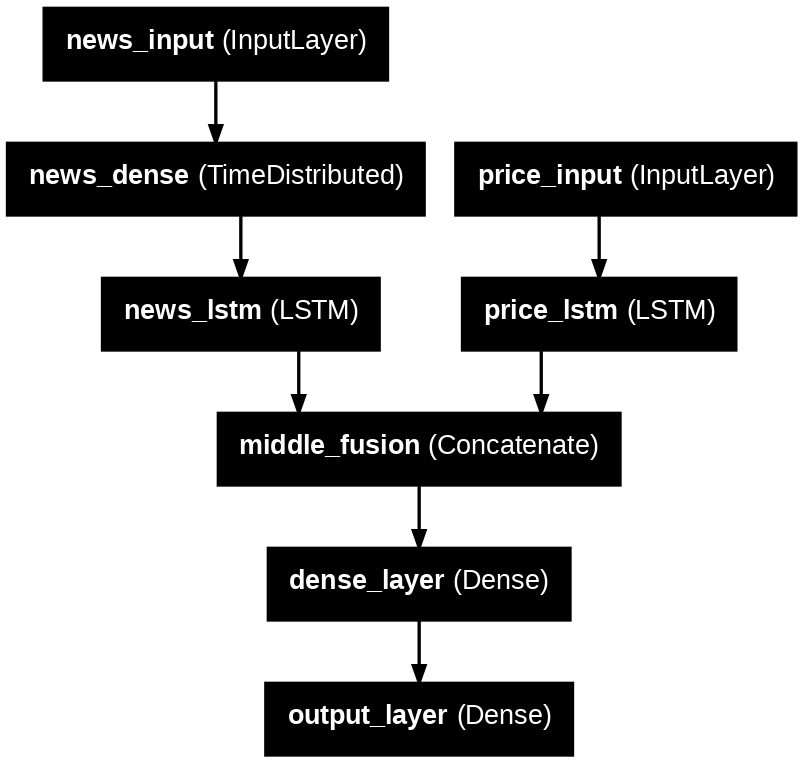

In [ ]:
# 作業：修改這裡的 fusion_type 參數！
# ============================================
fusion_type = "middle"  # ← 在這裡修改：early, middle, late
# ============================================

multimodal = build_multimodal_model(sequence_length=5, fusion_type=fusion_type)
multimodal.summary()

plot_model(
  multimodal, # 模型
  to_file=f'./{fusion_type}_fusion_model.png', # 可視化圖儲存路徑
  show_shapes=False,  # 顯示維度
  show_layer_names=True, # 顯示模型名稱
  dpi=120 # 解析度
  )

# 顯示圖片（在 Colab 中）
from IPython.display import Image, display
print(f"{fusion_type.upper()} 融合模型架構圖：")
display(Image(f'./{fusion_type}_fusion_model.png'))

In [ ]:
"""## 訓練模型"""

print(f"開始訓練 {fusion_type.upper()} 融合模型...")
start_time = time.time()

history = multimodal.fit(
    [X_price_train_scaled, X_news_train], # X (股價, 新聞)，順序需對應模型定義時的結構
    y_train, # y (漲或跌)
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

training_time = time.time() - start_time
print(f"訓練時間: {training_time:.1f} 秒")

開始訓練 MIDDLE 融合模型...
Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6369 - loss: 0.6549 - val_accuracy: 0.6508 - val_loss: 0.6429
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6179 - loss: 0.6478 - val_accuracy: 0.6508 - val_loss: 0.6922
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6969 - loss: 0.5941 - val_accuracy: 0.6508 - val_loss: 0.6488
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6670 - loss: 0.6079 - val_accuracy: 0.6508 - val_loss: 0.7348
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6912 - loss: 0.5685 - val_accuracy: 0.6508 - val_loss: 0.8533
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7292 - loss: 0.5386 - val_accuracy: 0.6508 - val_loss: 0.8679
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7876 - loss: 0.4548 - val_accuracy: 0.6576 - val_loss: 0.7049
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7848 - loss: 0.4784 - val_accura

# 結果評估

In [ ]:
"""# 結果評估"""

# 測試集評估
loss, accuracy = multimodal.evaluate([X_price_test_scaled, X_news_test], y_test, verbose=0)

print("="*50)
print(f"{fusion_type.upper()} 融合模型評估結果")
print("="*50)
print(f"測試準確率: {accuracy:.4f}")
print(f"參數量: {multimodal.count_params():,}")
print(f"訓練時間: {training_time:.1f} 秒")
print("="*50)

MIDDLE 融合模型評估結果
測試準確率: 0.7446
參數量: 33,953
訓練時間: 13.3 秒


In [ ]:
"""單模態對比實驗

實驗目標
比較單獨使用價格、單獨使用新聞、以及多模態融合的效果
證明多模態融合的價值，分析各模態的獨立貢獻

實驗設計
1. 純價格模型：相當於傳統技術分析
2. 純新聞模型：相當於純基本面分析
3. 多模態融合：結合兩種資訊源
"""

def build_price_only_model(sequence_length=5):
    """
    純價格模型：只使用技術指標預測
    相當於傳統的技術分析方法
    """
    print("建立純價格模型...")

    # 只有價格輸入
    price_input = Input(shape=(sequence_length, 3), name='price_input')

    # 直接用LSTM處理價格時間序列
    price_lstm = LSTM(32, name='price_lstm')(price_input)
    price_lstm = Dropout(0.2)(price_lstm)

    # 輸出層
    dense = Dense(32, activation='relu', name='dense_layer')(price_lstm)
    output = Dense(1, activation='sigmoid', name='output_layer')(dense)

    # 建立模型
    model = Model(inputs=price_input, outputs=output, name='price_only_model')

    # 編譯模型
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    print(f"純價格模型建立完成！參數量: {model.count_params():,}")

    return model

def build_news_only_model(sequence_length=5):
    """
    純新聞模型：只使用文本情感預測
    相當於純基本面分析方法
    """
    print("建立純新聞模型...")

    # 只有新聞輸入
    news_input = Input(shape=(sequence_length, 768), name='news_input')

    # 新聞特徵處理
    news_dense = TimeDistributed(Dense(32, activation='relu'), name='news_dense')(news_input)
    news_lstm = LSTM(16, name='news_lstm')(news_dense)
    news_lstm = Dropout(0.2)(news_lstm)

    # 輸出層
    dense = Dense(32, activation='relu', name='dense_layer')(news_lstm)
    output = Dense(1, activation='sigmoid', name='output_layer')(dense)

    # 建立模型
    model = Model(inputs=news_input, outputs=output, name='news_only_model')

    # 編譯模型
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    print(f"純新聞模型建立完成！參數量: {model.count_params():,}")

    return model

def train_and_evaluate_single_model(model, X_train, y_train, X_test, y_test, model_name, epochs=15):
    """
    訓練和評估單一模型的統一函數
    """
    print(f"\n 開始訓練 {model_name} 模型...")

    # 記錄訓練時間
    start_time = time.time()

    # 訓練模型
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=32,
        verbose=1
    )

    training_time = time.time() - start_time

    # 測試評估
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # 保存結果
    result = {
        'model_name': model_name,
        'model': model,
        'history': history,
        'training_time': training_time,
        'test_accuracy': test_accuracy,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob.flatten(),
        'parameter_count': model.count_params()
    }

    print(f"  {model_name} 訓練完成")
    print(f"   訓練時間: {training_time:.1f} 秒")
    print(f"   測試準確率: {test_accuracy:.4f}")

    return result

# 執行單模態對比實驗
print("\n" + "="*60)
print("單模態 vs 多模態對比實驗")
print("="*60)

comparison_results = {}

# 實驗1：純價格模型（技術分析）
print(f"\n{'='*20} 實驗1：純價格模型 {'='*20}")
price_model = build_price_only_model(sequence_length=5)
comparison_results['price_only'] = train_and_evaluate_single_model(
    price_model, X_price_train_scaled, y_train, X_price_test_scaled, y_test,
    "純價格模型"
)

# 實驗2：純新聞模型（基本面分析）
print(f"\n{'='*20} 實驗2：純新聞模型 {'='*20}")
news_model = build_news_only_model(sequence_length=5)
comparison_results['news_only'] = train_and_evaluate_single_model(
    news_model, X_news_train, y_train, X_news_test, y_test,
    "純新聞模型"
)

# 實驗3：多模態融合模型（重新訓練當前設定的融合類型）
comparison_results['multimodal'] = train_and_evaluate_single_model(
    multimodal, [X_price_train_scaled, X_news_train], y_train,
    [X_price_test_scaled, X_news_test], y_test, f"多模態融合({fusion_type.upper()})"
)

"""## 對比結果分析與視覺化"""

# 建立對比表格
print("\n" + "="*60)
print("單模態 vs 多模態實驗結果分析")
print("="*60)

"""## 實驗洞察與結論"""

# 提取準確率進行分析
price_acc = comparison_results['price_only']['test_accuracy']
news_acc = comparison_results['news_only']['test_accuracy']
multi_acc = comparison_results['multimodal']['test_accuracy']

# 計算提升幅度
best_single = max(price_acc, news_acc)
improvement = (multi_acc - best_single) / best_single * 100

print(f"1. 純價格模型準確率: {price_acc:.1%}")
print(f"2. 純新聞模型準確率: {news_acc:.1%}")
print(f"3. 多模態融合準確率: {multi_acc:.1%}")
print(f"4. 多模態相對最佳單模態提升: {improvement:+.1f}%")

print(f"\n實驗結論:")

if multi_acc > best_single:
    print("多模態融合顯著優於單模態方法")
    print("證明了價格和新聞資訊的互補性")
    print("驗證了多模態學習的價值")
else:
    print("多模態融合未顯示明顯優勢")
    print("可能的原因：")
    print("   - 資料品質問題")
    print("   - 融合策略需要優化")
    print("   - 模型架構需要調整")

# 分析各模態的獨立貢獻
if price_acc > news_acc:
    print(f"\n技術分析 vs 基本面分析:")
    print(f"   純技術分析更有效 ({price_acc:.1%} vs {news_acc:.1%})")
    print(f"   價格模式比新聞情感更具預測力")
else:
    print(f"\n基本面分析 vs 技術分析:")
    print(f"   純基本面分析更有效 ({news_acc:.1%} vs {price_acc:.1%})")
    print(f"   新聞情感比價格模式更具預測力")



單模態 vs 多模態對比實驗

==================== 實驗1：純價格模型 ====================
建立純價格模型...
純價格模型建立完成！參數量: 5,697

 開始訓練 純價格模型 模型...
Epoch 1/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6484 - loss: 0.6649 - val_accuracy: 0.6508 - val_loss: 0.6580
Epoch 2/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6164 - loss: 0.6668 - val_accuracy: 0.6508 - val_loss: 0.6585
Epoch 3/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6404 - loss: 0.6410 - val_accuracy: 0.6508 - val_loss: 0.6555
Epoch 4/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6303 - loss: 0.6552 - val_accuracy: 0.6508 - val_loss: 0.6723
Epoch 5/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6613 - loss: 0.6297 - val_accuracy: 0.6508 - val_loss: 0.6392
Epoch 6/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6536 - loss: 0.6325 - val_accuracy: 0.6508 - val_loss: 0.6837
Epoch 7/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6574 - loss: 0.6214 - val_accuracy: 0.6508 - val_loss: 0.72

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!find /content -name "1022_week7_多模態 Multimodal"

/content/drive/MyDrive/Colab Notebooks/1022_week7_多模態 Multimodal


In [ ]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --inplace --to notebook '/content/drive/MyDrive/Colab Notebooks/1022_week7_多模態 Multimodal'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/1022_week7_多模態 Multimodal to notebook
[NbConvertApp] Writing 290971 bytes to /content/drive/MyDrive/Colab Notebooks/1022_week7_多模態 Multimoda.ipynb
